In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
n225_df = pd.read_csv('./data/nikkei_stock_average_daily_jp.csv',
                      parse_dates=True, index_col=['Date'])
vi_df = pd.read_csv('./data/nikkei_stock_average_vi_daily_jp.csv',
                    parse_dates=True, index_col=['Date'])

n225_vi_df = pd.concat([n225_df['Close'], vi_df['Close']], axis=1)
n225_vi_df.columns = ['n225', 'VI']
n225_vi_df.dropna(inplace=True)

s_df = pd.read_pickle('./data/s.pickle')
op_pn1 = pd.read_pickle('./data/op1.pickle')
op_pn2 = pd.read_pickle('./data/op2.pickle')
op_pn = {'1803': op_pn1, '1804': op_pn2}

### ボラティリティの特性

* 権利行使価格ごとに異なる
* プットのIV > コールのIV
* ATM付近が最も低くなる

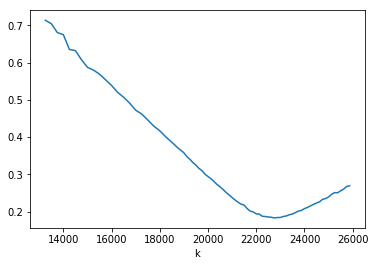

In [3]:
op_pn['1803'].loc['2018-02-16 15:15']['iv'].plot();

### ボラティリティの変化

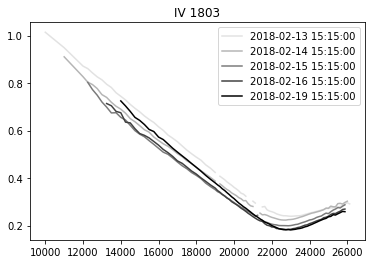

In [4]:
n = 5
periods = op_pn['1803'].keys()
colors = plt.get_cmap('Greys')(np.linspace(0, 1, n + 1))[1:]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i in range(n):
    label = periods[i]
    x = op_pn['1803'].loc[periods[i]].index
    y = op_pn['1803'].loc[periods[i]]['iv']
    ax.plot(x, y, color=colors[i], label=label)

ax.set_title('IV 1803')
ax.legend()
plt.show()

* 権利行使価格が多数ある
* 限月が複数ある
* 全てのデータを時系列に並べるのは非現実的
* 一つの指標としてまとまったものがあると便利

### 日経平均ボラティリティー・インデックス

* オプションのプレミアムを元に算出した指標
* 日経平均株価の将来の変動をどのように想定しているかがわかる
* 満期が30日になるように線形補間

> 参考: 日経平均プロフィル -> 日経平均ボラティリティー・インデックス  
> https://indexes.nikkei.co.jp/nkave/index/profile?idx=nk225vi

### 時系列データ

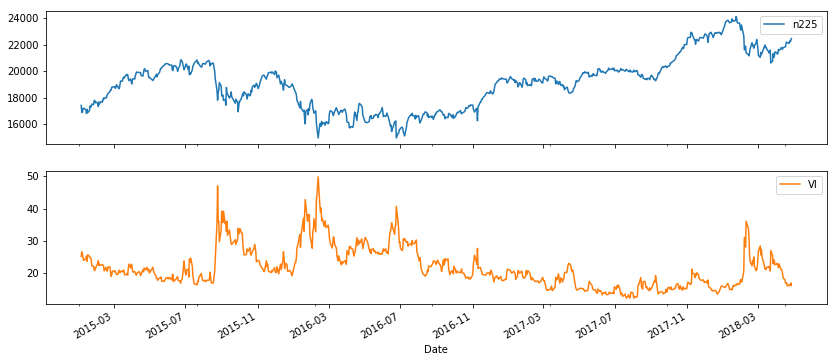

In [5]:
n225_vi_df.dropna().plot(subplots=True, figsize=(14, 6));

* ボラティリティが急激に上昇したら、急激に下落する  
  -> ボラティリティスパイク
* 平均回帰性
* 原資産価格の変動と比較して、特性があり動きが読みやすい

### 日経平均株価とVIの相関

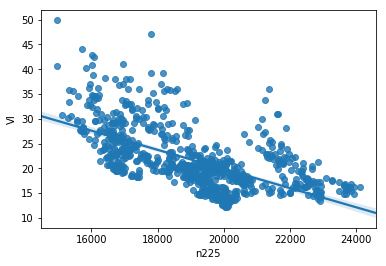

In [6]:
sns.regplot(x='n225', y='VI', data=n225_vi_df);

In [7]:
model = sm.OLS(n225_vi_df['VI'], n225_vi_df['n225'])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     VI   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     6058.
Date:                Sat, 26 May 2018   Prob (F-statistic):               0.00
Time:                        16:55:14   Log-Likelihood:                -2823.2
No. Observations:                 815   AIC:                             5648.
Df Residuals:                     814   BIC:                             5653.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
n225           0.0011   1.41e-05     77.833      0.000       0.001       0.001
==============================================================================
Omnibus:                       82.302   Durbin-Watson:                   0.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.243
Skew:                           0.854   Prob(JB):                     1.40e-23
Kurtosis:                       3.428   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* 日経平均株価とVIには負の相関がある
* 特に原資産価格が急落した場合にはボラティリティが上昇しやすい